In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import os
import math

In [3]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

<AxesSubplot: >

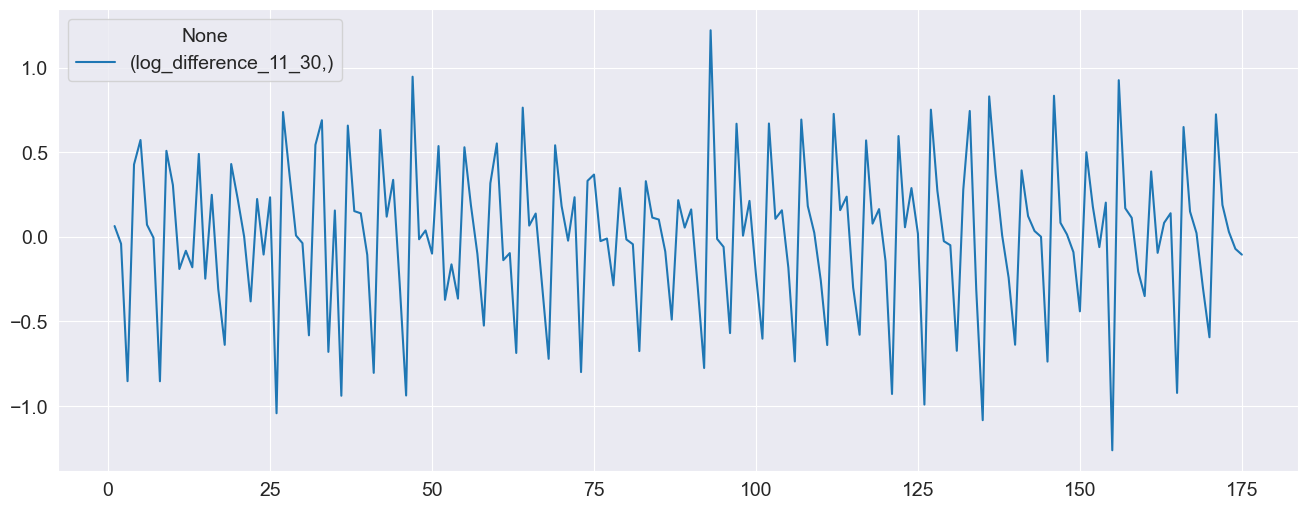

In [19]:
pickle_path = os.path.join('..', '..', 'data', 'features_by_date')
features_by_date = pd.read_pickle(pickle_path)
df=pd.DataFrame(data=features_by_date['filled_num_people_11_30'].values, columns=[['num_people_11_30']])
df['log_11_30']=df.apply(lambda row: math.log(row['num_people_11_30']),axis=1)
df['log_11_30_1d_ago']=df['log_11_30'].shift(1)
df['log_difference_11_30']=df.apply(lambda row: row['log_11_30']-row['log_11_30_1d_ago'],axis=1)
df.dropna(axis=0, inplace=True)
df['log_difference_11_30'].plot()


P-value:  0.0


C:\Users\mefl\AppData\Local\pypoetry\Cache\virtualenvs\food-saving-showcase-ocOVEVjy-py3.10\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


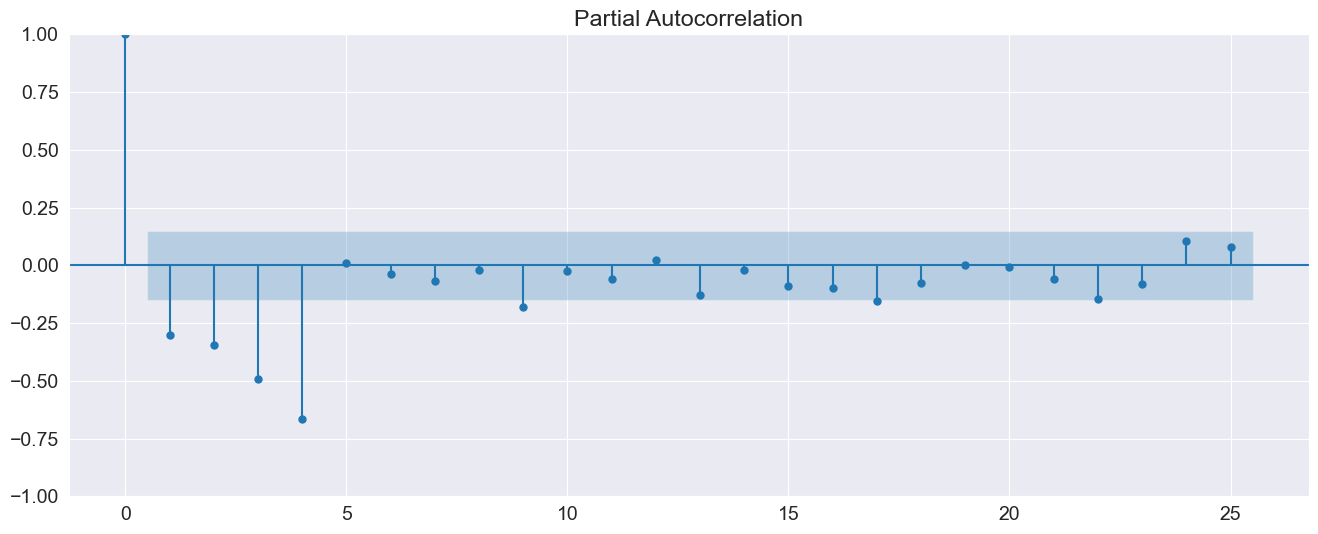

In [33]:
#
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series
# data can said to have stationarity
#
from statsmodels.tsa.stattools import adfuller
#
# Run the test
#
df_stationarityTest = adfuller(df['log_difference_11_30'], autolag='AIC')
#
# Check the value of p-value
#
print("P-value: ", df_stationarityTest[1])
#
# Next step is to find the order of AR model to be trained
# for this, we will plot partial autocorrelation plot to assess
# the direct effect of past data on future data
#
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(df['log_difference_11_30'], lags=25)

In [78]:
#
# Create training and test data
#
train_data = df['log_difference_11_30'][:len(df)-50]
test_data = df['log_difference_11_30'][len(df)-50:]
all_data=df['log_difference_11_30']
#
# Instantiate and fit the AR model with training data
#
ar_model_seas = AutoReg(all_data, lags=5,seasonal=True,period=5).fit()
ar_model = AutoReg(all_data, lags=5).fit()
#
# Print Summary
#
print(ar_model.summary())

                             AutoReg Model Results                              
Dep. Variable:     log_difference_11_30   No. Observations:                  175
Model:                       AutoReg(5)   Log Likelihood                 -22.559
Method:                 Conditional MLE   S.D. of innovations              0.276
Date:                  Tue, 13 Dec 2022   AIC                             59.119
Time:                          11:18:17   BIC                             81.069
Sample:                               5   HQIC                            68.026
                                    175                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0166      0.021      0.780      0.435      -0.025       0.058
log_difference_11_30.L1    -0.8552      0.077    -11.081      0.000      -1.

C:\Users\mefl\AppData\Local\pypoetry\Cache\virtualenvs\food-saving-showcase-ocOVEVjy-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mefl\AppData\Local\pypoetry\Cache\virtualenvs\food-saving-showcase-ocOVEVjy-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\mefl\AppData\Local\Temp\ipykernel_11712\2545800069.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pred=pd.Series()
C:\Users\mefl\AppData\Local\Temp\ipykernel_11712\2545800069.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(new_pred)
C:\Users\mefl\AppData\Local\Temp\ipykernel_11712\2545800069.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(new_pred)
C:\Users\mefl\AppData\Local\Temp\ipykernel_11712\2545800069.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(new_pred)
C:\Users\mefl\AppData\Local\Temp\ipykernel_11712\2545800069.py:7: F

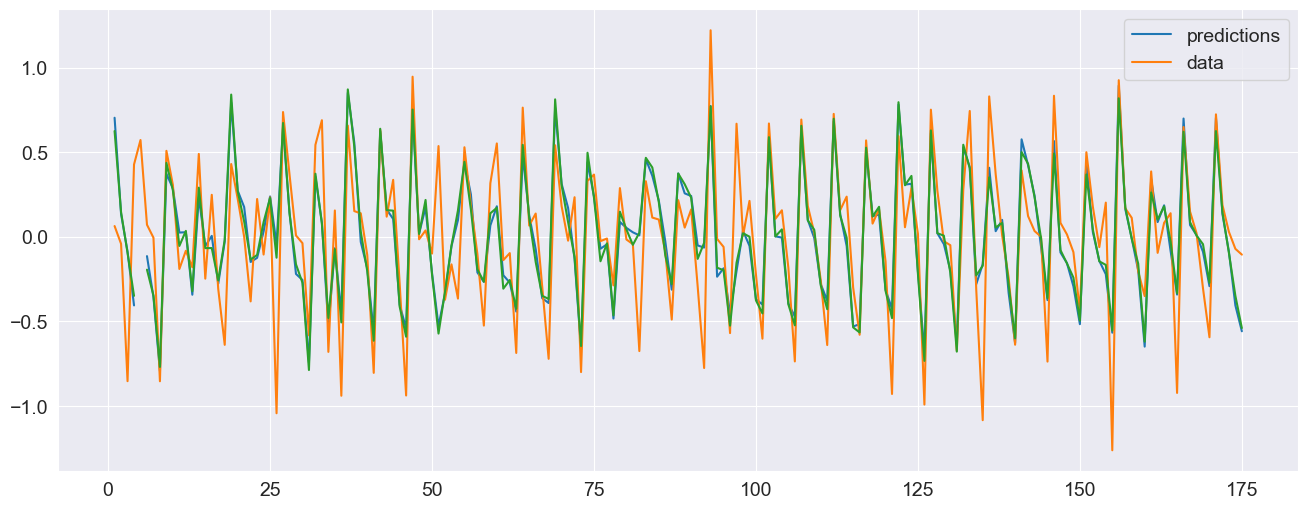

In [122]:
# Make the predictions
#
# pred=ar_model.predict(start=len(train_data),end=len(train_data),dynamic=False)
pred=pd.Series()
for i in range(0,len(df)):
    new_pred=ar_model.predict(start=i,end=i,dynamic=False)
    pred=pred.append(new_pred)

pred_seas=pd.Series()
for i in range(0,len(df)):
    new_pred_seas=ar_model_seas.predict(start=i,end=i,dynamic=False)
    pred_seas=pred_seas.append(new_pred_seas)

#
# from matplotlib import pyplot
plt.plot(pred)
plt.plot(all_data)
plt.plot(pred_seas)

plt.legend(['predictions','data'])

In [123]:
df_2=df['log_11_30'].shift(1)
back_transform=pd.DataFrame(pred, columns=['pred_log_dif']).join(df_2).rename(columns={('log_11_30',):'log_11_30'})

In [124]:
back_transform= back_transform.apply(lambda row: math.exp( row['pred_log_dif']+row['log_11_30']), axis=1)

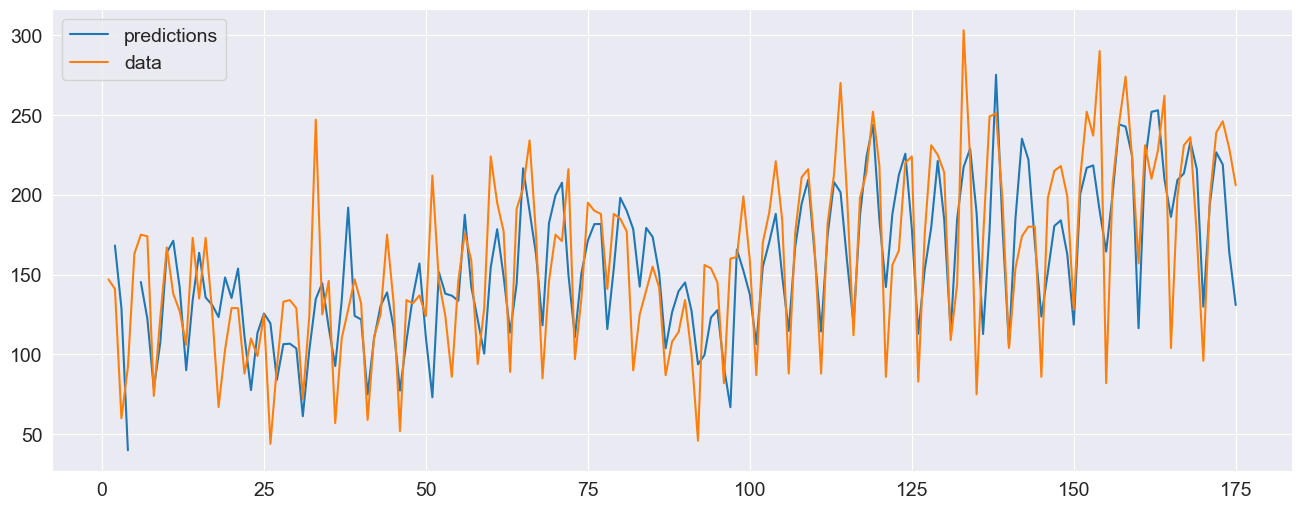

In [125]:
plt.plot(back_transform)
plt.plot(df['num_people_11_30'])
plt.legend(['predictions','data'])

In [115]:
df

,num_people_11_30,log_11_30,log_11_30_1d_ago,log_difference_11_30
1,147.0,4.990433,4.927254,0.063179
2,141.0,4.948760,4.990433,-0.041673
3,60.0,4.094345,4.948760,-0.854415
4,92.0,4.521789,4.094345,0.427444
5,163.0,5.093750,4.521789,0.571962
...,...,...,...,...
171,198.0,5.288267,4.564348,0.723919
172,239.0,5.476464,5.288267,0.188197
173,246.0,5.505332,5.476464,0.028868
174,229.0,5.433722,5.505332,-0.071610


C:\Users\mefl\AppData\Local\Temp\ipykernel_11712\2422367398.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pred=pd.Series()
C:\Users\mefl\AppData\Local\Temp\ipykernel_11712\2422367398.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(new_pred)
C:\Users\mefl\AppData\Local\Temp\ipykernel_11712\2422367398.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(new_pred)
C:\Users\mefl\AppData\Local\Temp\ipykernel_11712\2422367398.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred=pred.append(new_pred)
C:\Users\mefl\AppData\Local\Temp\ipykernel_11712\2422367398.py:7: F

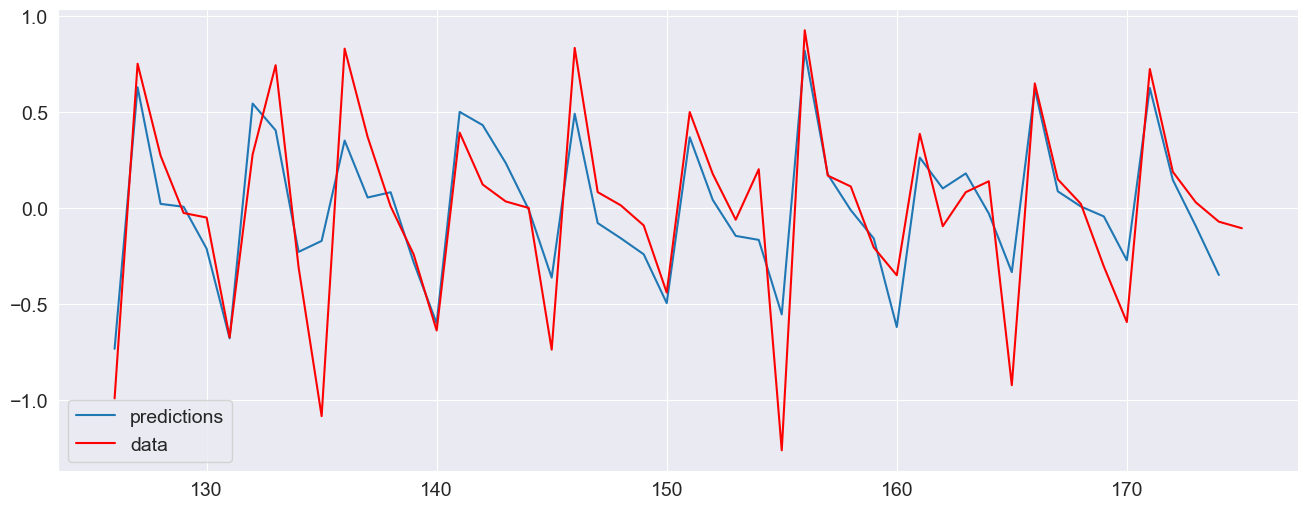

In [75]:
# Make the predictions
#
# pred=ar_model.predict(start=len(train_data),end=len(train_data),dynamic=False)
pred=pd.Series()
for i in range(len(train_data),len(df)-1):
    new_pred=ar_model.predict(start=i,end=i,dynamic=False)
    pred=pred.append(new_pred)

#
# from matplotlib import pyplot
plt.plot(pred)
plt.plot(test_data, color='red')
plt.legend(['predictions','data'])

In [71]:
pred

125   -0.662106
126    0.340718
127    0.058201
128    0.239468
129   -0.126759
130   -0.349419
131    0.205556
132    0.075559
133    0.158597
134   -0.152234
135   -0.181092
136    0.127861
137    0.079816
138    0.089472
139   -0.132851
140   -0.091995
141    0.084882
142    0.072130
143    0.042168
144   -0.102162
145   -0.044931
146    0.060623
147    0.058569
148    0.014011
149   -0.073337
150   -0.019861
151    0.045791
152    0.044058
153   -0.000675
154   -0.050280
155   -0.006372
156    0.035644
157    0.031311
158   -0.007007
159   -0.033170
160    0.000870
161    0.028008
162    0.021326
163   -0.008661
164   -0.020983
165    0.004631
166    0.021965
167    0.014106
168   -0.007974
169   -0.012521
170    0.006397
171    0.017134
172    0.009211
173   -0.006312
dtype: float64

In [27]:
mod = AutoReg(df['log_difference_11_30'], 5, old_names=False)
res = mod.fit()
print(res.summary())

                             AutoReg Model Results                              
Dep. Variable:     log_difference_11_30   No. Observations:                  175
Model:                       AutoReg(5)   Log Likelihood                 -22.559
Method:                 Conditional MLE   S.D. of innovations              0.276
Date:                  Tue, 13 Dec 2022   AIC                             59.119
Time:                          09:41:53   BIC                             81.069
Sample:                               5   HQIC                            68.026
                                    175                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0166      0.021      0.780      0.435      -0.025       0.058
log_difference_11_30.L1    -0.8552      0.077    -11.081      0.000      -1.

C:\Users\mefl\AppData\Local\pypoetry\Cache\virtualenvs\food-saving-showcase-ocOVEVjy-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [30]:
mod = AutoReg(df['log_difference_11_30'], 5,seasonal=True, period=5, old_names=False)
res = mod.fit()
print(res.summary())

                             AutoReg Model Results                              
Dep. Variable:     log_difference_11_30   No. Observations:                  175
Model:                 Seas. AutoReg(5)   Log Likelihood                 -20.696
Method:                 Conditional MLE   S.D. of innovations              0.273
Date:                  Tue, 13 Dec 2022   AIC                             63.392
Time:                          09:46:39   BIC                             97.886
Sample:                               5   HQIC                            77.389
                                    175                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0565      0.048     -1.167      0.243      -0.151       0.038
s(2,5)                      0.0914      0.069      1.320      0.187      -0.

C:\Users\mefl\AppData\Local\pypoetry\Cache\virtualenvs\food-saving-showcase-ocOVEVjy-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


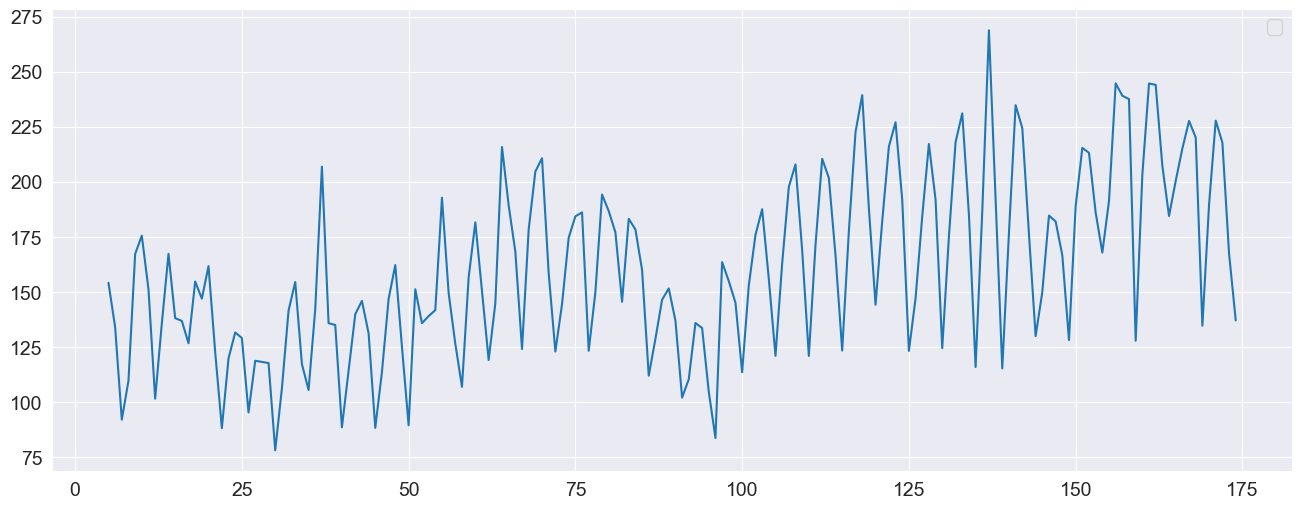

In [26]:
fig = res.plot_predict()

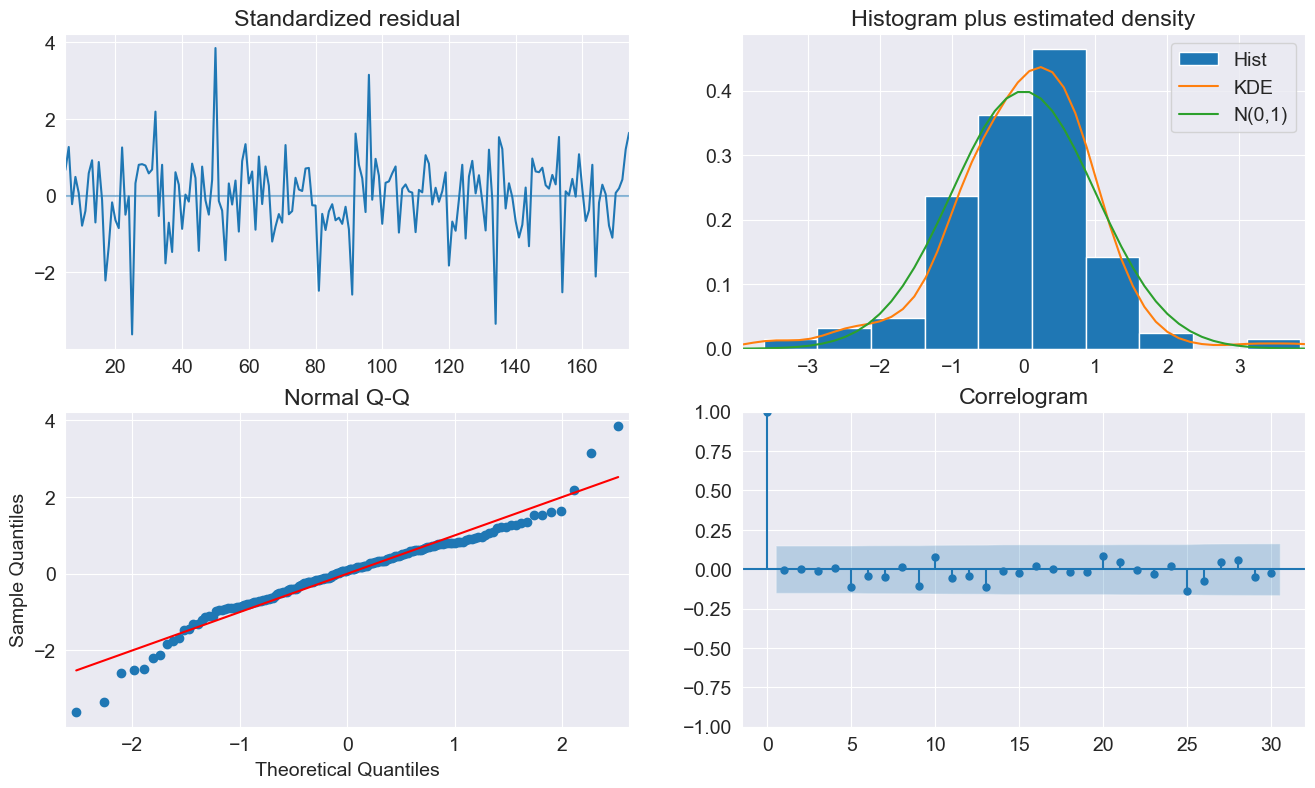

In [24]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

In [11]:
mod = AutoReg(housing, 3, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(3)   Log Likelihood               -2993.442
Method:               Conditional MLE   S.D. of innovations             15.289
Date:                Tue, 13 Dec 2022   AIC                           5996.884
Time:                        09:11:21   BIC                           6019.794
Sample:                    05-01-1959   HQIC                          6005.727
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1228      0.573      1.961      0.050       0.000       2.245
HOUSTNSA.L1     0.1910      0.036      5.235      0.000       0.120       0.263
HOUSTNSA.L2     0.0058      0.037      0.155    

In [17]:
mod = AutoReg(housing, 3, old_names=False)
res = mod.fit()
print(res.summary())

In [9]:
data

,HOUSTNSA
DATE,
1959-01-01,96.2
1959-02-01,99.0
1959-03-01,127.7
1959-04-01,150.8
1959-05-01,152.5
...,...
2019-02-01,80.0
2019-03-01,98.2
2019-04-01,116.6
